<a href="https://colab.research.google.com/github/Apple03244/Colaboratory/blob/main/wide%26deep_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import google.colab as colab
import pandas as pd
f=colab.files
files=f.upload()

Saving train.csv to train.csv


In [3]:
  data=pd.read_csv("/content/train.csv")

## step 1. 전처리
이전과 같으므로 설명 생략

In [4]:
import sklearn.preprocessing as skpre
import sklearn.pipeline as skpip
import sklearn.model_selection as skmod
import sklearn.impute as skimp
import sklearn.compose as skcomp
import tensorflow as ts
import tensorflow.keras as tk
data["일시"]=data["일시"].apply(lambda x:pd.to_datetime(x))
ts.random.set_seed(10)
target='평균기온'
wide_feature=["최고기온","최저기온"]
deep_feature=data.columns.difference([target,"일시"]+wide_feature)

In [5]:
fill_na=skpip.make_pipeline(skimp.SimpleImputer(strategy="constant",fill_value=0))
preprocess=skcomp.make_column_transformer((fill_na,data.columns.difference(["일시",target])),remainder='passthrough')
def drop_(x):
  for t in ["pipeline__","remainder__"]:
    x=x.replace(t,"")
  return x
preprocess.fit(X=data)
columns_name=list(map(drop_,preprocess.get_feature_names_out()))
trans_data=pd.DataFrame(preprocess.transform(X=data)
,columns=columns_name)
trans_data[trans_data.select_dtypes("object").columns]=trans_data.select_dtypes("object").astype('float')

## step 2. wide & deep model type 3

### 모델 구조 생성

In [6]:
# 1-1. input 2개
input_wide_layer=tk.Input(shape=trans_data[wide_feature].shape[1:])
input_deep_layer=tk.Input(shape=trans_data[deep_feature].shape[1:])
# 2-1. 정규화
normal_wide_layer=tk.layers.Normalization()
normal_deep_layer=tk.layers.Normalization()
# 2-2. 정규화 진행
normal_wide=normal_wide_layer(input_wide_layer)
normal_deep=normal_deep_layer(input_deep_layer)
# 3-1. 경로 생성
deep_1=tk.layers.Dense(units=30,activation='sigmoid')(normal_deep)
deep_2=tk.layers.Dense(units=30,activation='sigmoid')(deep_1)
# 4-1. concate
concate=tk.layers.Concatenate()([normal_wide,deep_2])
# 5-1. output
output=tk.layers.Dense(1)(concate)
sub_output=tk.layers.Dense(1)(deep_2)

위의 모델은 input 2& output 2개로 이루어진 모델임을 알 수 있다

In [7]:
# 6-1. make model
type_3_model=tk.Model(inputs=(input_wide_layer,input_deep_layer),outputs=(output,sub_output))

In [8]:
# 7-1. compile
optimizer=tk.optimizers.SGD(learning_rate=0.01)
loss=tk.losses.mae
type_3_model.compile(optimizer=optimizer,loss=(loss,loss),metrics=["RootMeanSquaredError"],loss_weights=(0.9,0.1),run_eagerly=True)

In [9]:
import numpy as np
np.random.seed(10)
train,test=skmod.train_test_split(trans_data,train_size=0.7,random_state=10)

In [10]:
# 8-1. model fitting
normal_wide_layer.adapt(train[wide_feature])
normal_deep_layer.adapt(train[deep_feature])
train_x=(train[wide_feature],train[deep_feature])
test_x=(test[wide_feature],test[deep_feature])
run_history=type_3_model.fit(x=train_x,y=train[target],epochs=10,validation_data=(test_x,test[target]),workers=-1)

Epoch 1/10
504/504 [==============================] - 25s 50ms/step - loss: 7.7031 - dense_2_loss: 7.1879 - dense_3_loss: 12.3400 - dense_2_root_mean_squared_error: 9.0230 - dense_3_root_mean_squared_error: 14.7188 - val_loss: 3.9105 - val_dense_2_loss: 3.0891 - val_dense_3_loss: 11.3035 - val_dense_2_root_mean_squared_error: 3.6121 - val_dense_3_root_mean_squared_error: 13.3949
Epoch 2/10
504/504 [==============================] - 24s 47ms/step - loss: 1.9790 - dense_2_loss: 1.0136 - dense_3_loss: 10.6681 - dense_2_root_mean_squared_error: 1.5497 - dense_3_root_mean_squared_error: 12.5433 - val_loss: 1.3917 - val_dense_2_loss: 0.4243 - val_dense_3_loss: 10.0991 - val_dense_2_root_mean_squared_error: 0.5693 - val_dense_3_root_mean_squared_error: 11.7488
Epoch 3/10
504/504 [==============================] - 23s 46ms/step - loss: 1.3555 - dense_2_loss: 0.4157 - dense_3_loss: 9.8139 - dense_2_root_mean_squared_error: 0.5562 - dense_3_root_mean_squared_error: 11.3280 - val_loss: 1.3177 - v

In [13]:
import matplotlib.pyplot as plt
import seaborn as sb
his_data=pd.DataFrame(run_history.history)

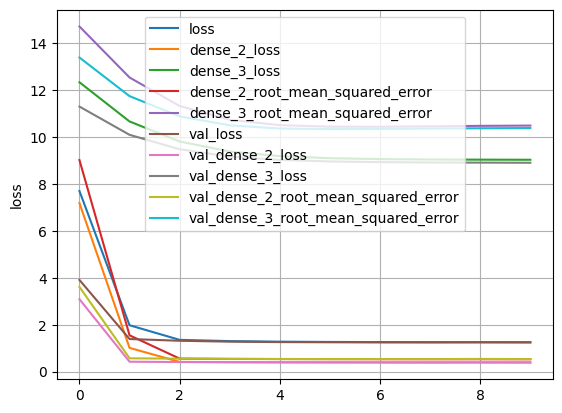

In [15]:
plt.figure()
for col in his_data.columns:
  sb.lineplot(x=his_data.index,y=his_data[col],label=col)
plt.grid()